In [ ]:
import os
import sys
import json
from typing import Dict, Any
from dataclasses import dataclass
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

# ---------- USER CONFIG ----------
AUDIO_PATH = "/home/fizah/Projects/quids/live/trackcheck/mlend/audios/euro-bass-line-electro-buzz-loop_125bpm_A_minor.wav" 
PROJECT_ROOT = "/home/fizah/Projects/quids/live/trackcheck" 
PACKAGE_IMPORT = "app.services.audio_service"  
# ---------------------------------

# Make project importable if a root is provided
if PROJECT_ROOT and PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

extract_features = None
features_to_payload = None


# Try to import user's real audio service first
try:
    mod = __import__(PACKAGE_IMPORT, fromlist=['extract_features', 'features_to_payload'])
    extract_features = getattr(mod, 'extract_features', None)
    features_to_payload = getattr(mod, 'features_to_payload', None)
except Exception as e:
    print(f"[Info] Could not import '{PACKAGE_IMPORT}': {e}")

In [5]:


# # Fallback to local reference implementation if import failed
# if extract_features is None or features_to_payload is None:
#     print("[Info] Using fallback in-notebook reference implementation.")
    
#     @dataclass
#     class AudioFeatures:
#         tempo: float
#         key: str
#         duration: float
#         peak_rms: float
#         spectral: Dict[str, float]
#         dynamics: Dict[str, Any]
#         vocals: Dict[str, Any]
#         structure: Dict[str, Any]
#         fx_transitions: Dict[str, Any]

#     def _estimate_key(y: np.ndarray, sr: int) -> str:
#         chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
#         chroma_mean = chroma.mean(axis=1)
#         pitch_class = int(chroma_mean.argmax())
#         keys = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
#         centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
#         is_minor = centroid < (sr/8)
#         return f"{keys[pitch_class]}{'m' if is_minor else ''}"

#     def extract_features(path) -> AudioFeatures:
#         y, sr = librosa.load(path, mono=True, sr=None)
#         duration = librosa.get_duration(y=y, sr=sr)

#         # Tempo
#         tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

#         # RMS / Peak RMS
#         rms = librosa.feature.rms(y=y)[0]
#         peak_rms = float(np.max(rms))

#         # Spectral stats
#         centroid = float(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
#         rolloff = float(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))
#         bandwidth = float(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
#         flatness = float(np.mean(librosa.feature.spectral_flatness(y=y)))

#         # Dynamics / Energy profile
#         rms_times = librosa.times_like(rms, sr=sr)
#         energy_profile = [{"t": float(t), "rms": float(v)} for t, v in zip(rms_times, rms)]
#         # simple transient detection: local maxima above threshold
#         diff = np.diff(rms, prepend=rms[0])
#         thr = np.percentile(diff, 95)
#         transients = [float(rms_times[i]) for i in np.where(diff > thr)[0]]

#         # Vocal proxy
#         H, P = librosa.effects.hpss(y)
#         vocal_intensity = float(np.mean(np.abs(H)))
#         vocal_sections = []  # placeholder

#         # Structure (coarse) - find "drops"
#         onset_env = librosa.onset.onset_strength(y=y, sr=sr)
#         times = librosa.times_like(onset_env, sr=sr)
#         peaks = librosa.util.peak_pick(onset_env, pre_max=16, post_max=16, pre_avg=16, post_avg=16, delta=0.7, wait=5)
#         drop_timestamps = [float(times[p]) for p in peaks[:5]]

#         features = AudioFeatures(
#             tempo=float(tempo),
#             key=_estimate_key(y, sr),
#             duration=float(duration),
#             peak_rms=peak_rms,
#             spectral={
#                 "centroid": centroid,
#                 "rolloff": rolloff,
#                 "bandwidth": bandwidth,
#                 "flatness": flatness,
#             },
#             dynamics={
#                 "energy_profile": energy_profile,
#                 "transients": transients,
#             },
#             vocals={
#                 "vocal_intensity": vocal_intensity,
#                 "vocal_timestamps": vocal_sections,
#             },
#             structure={
#                 "drop_timestamps": drop_timestamps,
#                 "notes": "Heuristic segmentation; replace with Essentia or dedicated model.",
#             },
#             fx_transitions={
#                 "notable": [],
#             },
#         )
#         # Attach raw arrays that are useful for plotting/diagnostics
#         features._debug = {
#             "y": y,
#             "sr": sr,
#             "rms": rms,
#             "rms_times": rms_times,
#             "onset_env": onset_env,
#             "onset_env_times": times,
#         }
#         return features

#     def features_to_payload(f) -> dict:
#         return {
#             "tempo": f.tempo,
#             "key": f.key,
#             "duration": f.duration,
#             "peak_rms": f.peak_rms,
#             "centroid": f.spectral["centroid"],
#             "rolloff": f.spectral["rolloff"],
#             "bandwidth": f.spectral["bandwidth"],
#             "flatness": f.spectral.get("flatness"),
#             "energy_profile": f.dynamics["energy_profile"],
#             "transients_info": f.dynamics["transients"],
#             "vocal_timestamps": f.vocals["vocal_timestamps"],
#             "vocal_intensity": f.vocals.get("vocal_intensity"),
#             "drop_timestamps": f.structure["drop_timestamps"],
#             "fx_and_transitions": f.fx_transitions["notable"],
#             "structure": f.structure.get("notes", ""),
#         }

# # ---------- Run if file is provided ----------
# if not AUDIO_PATH:
#     print("⚠️  Set AUDIO_PATH to a valid audio file path (WAV/MP3) and re-run this cell.")
# else:
#     if not os.path.exists(AUDIO_PATH):
#         print(f"❌ AUDIO_PATH not found: {AUDIO_PATH}")
#     else:
#         print(f"✅ Using audio file: {AUDIO_PATH}")

#         # 1) Extract features
#         feats = extract_features(AUDIO_PATH)

#         # 2) Build payload
#         payload = features_to_payload(feats)

#         # 3) Print summary
#         print("\n=== Feature Summary ===")
#         for k in ["tempo", "key", "duration", "peak_rms", "centroid", "rolloff", "bandwidth", "flatness"]:
#             v = payload.get(k, None)
#             print(f"{k:>12}: {v}")

#         print("\n=== Structure ===")
#         print("drop_timestamps:", payload.get("drop_timestamps", []))

#         print("\n=== Vocals ===")
#         print("vocal_intensity:", payload.get("vocal_intensity"))
#         print("vocal_timestamps:", payload.get("vocal_timestamps"))

#         # 4) Save payload and raw features for inspection
#         os.makedirs("data", exist_ok=True)
#         with open("data/feature_payload.json", "w") as f:
#             json.dump(payload, f, indent=2)
#         print("\n📦 Saved JSON payload -> data/feature_payload.json")

#         # Save some debug arrays if available
#         debug = getattr(feats, "_debug", None)
#         if debug:
#             np.save("data/waveform.npy", debug["y"])
#             np.save("data/rms.npy", debug["rms"])
#             np.save("data/rms_times.npy", debug["rms_times"])
#             np.save("data/onset_env.npy", debug["onset_env"])
#             np.save("data/onset_env_times.npy", debug["onset_env_times"])
#             print("📦 Saved debug arrays: waveform.npy, rms.npy, rms_times.npy, onset_env.npy, onset_env_times.npy in /mnt/data")

#         # 5) Simple plots (one per figure; no specified colors)
#         if debug:
#             y = debug["y"]
#             sr = debug["sr"]
#             t = np.arange(len(y)) / sr
#             plt.figure()
#             plt.title("Waveform")
#             plt.plot(t, y)
#             plt.xlabel("Time (s)")
#             plt.ylabel("Amplitude")
#             plt.show()

#             plt.figure()
#             plt.title("RMS over Time")
#             plt.plot(debug["rms_times"], debug["rms"])
#             plt.xlabel("Time (s)")
#             plt.ylabel("RMS")
#             plt.show()

#             plt.figure()
#             plt.title("Onset Strength (Novelty)")
#             plt.plot(debug["onset_env_times"], debug["onset_env"])
#             plt.xlabel("Time (s)")
#             plt.ylabel("Onset Strength")
#             plt.show()

# print("\nDone. You can download files from: data/feature_payload.json")


/home/fizah/miniconda3/envs/trackcheck311/lib/python3.11/site-packages/webrtcvad.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Python: 3.11.14 | OS: Linux 6.8.0-87-generic
librosa: 0.10.2.post1
Module: app.services.audio_service
Audio: /home/fizah/Projects/quids/live/trackcheck/mlend/audios/euro-bass-line-electro-buzz-loop_125bpm_A_minor.wav

=== Summary ===
Tempo        : 126.05 BPM
Key          : Am
Duration     : 18.4 s
Peak RMS     : 0.64
Centroid     : 656.49 Hz
Rolloff      : 1132.8 Hz
Bandwidth    : 1391.31 Hz
Flatness     : 0.0

Energy points: 1024 (downsampled ≤ 1024)
First 3 energy samples: [{'t': 0.0, 'rms': 0.21}, {'t': 0.01, 'rms': 0.29}, {'t': 0.03, 'rms': 0.43}]

Transients   : 65 (showing first 12)
[0.035, 0.255, 0.499, 0.743, 0.975, 1.219, 1.463, 1.695, 1.939, 2.183, 2.415, 2.659]

Vocal segs   : 0
Vocal intensity (coarse): 0.19

Drops        : 5 → [0.035, 0.255, 0.499, 0.743, 0.975]
FX events    : 8
First 3 FX   : [{'t': 4.08671201814059, 'type': 'glitch', 'confidence': 0.5}, {'t': 4.08671201814059, 'type': 'sweep', 'confidence': 0.4}, {'t': 8.17342403628118, 'type': 'riser', 'confidence': 0.

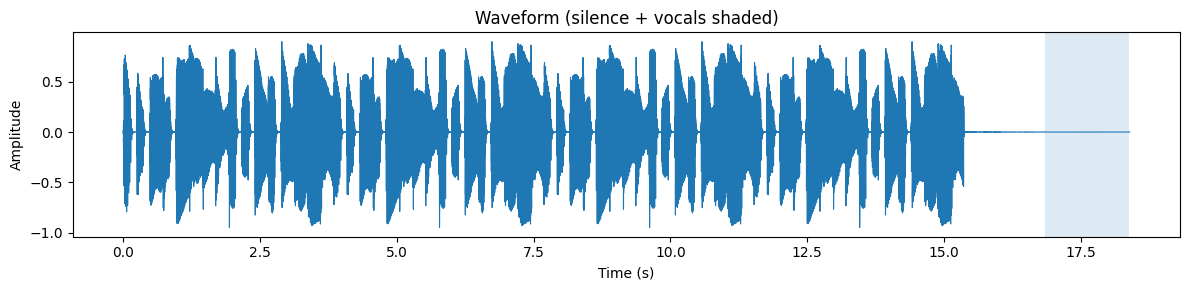

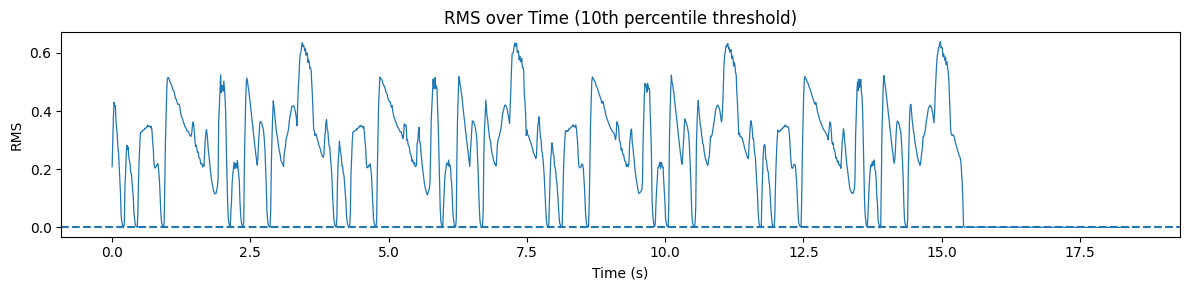

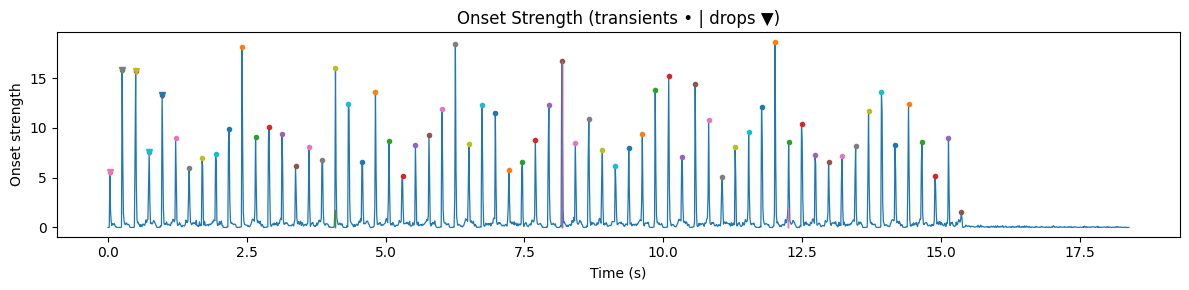


Done.


In [1]:
# === TrakChek feature extraction runner (strict env + rich plots) ==================
# Requires:
#   - Python 3.11+
#   - librosa >= 0.10
#   - webrtcvad (required; used for vocal timestamps)
# ================================================================================

import os, sys, json, math, platform, pathlib, importlib
from typing import Dict, Any, List
import numpy as np

# --- USER CONFIG ----------------------------------------------------------------
AUDIO_PATH     = "/home/fizah/Projects/quids/live/trackcheck/mlend/audios/euro-bass-line-electro-buzz-loop_125bpm_A_minor.wav"
PROJECT_ROOT   = "/home/fizah/Projects/quids/live/trackcheck"   # repo root containing 'app'
PACKAGE_IMPORT = "app.services.audio_service"                    # your module path
MAX_PRINT_TRANSIENTS = 12                                        # console preview
SHOW_FX = True                                                   # draw FX markers on plots
# -------------------------------------------------------------------------------

# Ensure project importable
if PROJECT_ROOT and PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# --- Hard asserts for environment ------------------------------------------------
def _ver_tuple(v: str) -> tuple:
    return tuple(int(x) for x in v.split(".") if x.isdigit())

import sys as _sys
py_ver = _ver_tuple(".".join(map(str, _sys.version_info[:3])))
assert py_ver >= (3, 11, 0), f"Python >= 3.11 required, found {sys.version.split()[0]}"

try:
    import librosa
except Exception as e:
    raise RuntimeError(f"librosa not installed: {e}")

lb_ver = _ver_tuple(librosa.__version__.split("+")[0])
assert lb_ver >= (0, 10, 0), f"librosa >= 0.10 required, found {librosa.__version__}"

try:
    import webrtcvad  # noqa: F401
except Exception as e:
    raise RuntimeError(f"webrtcvad is required for vocal timestamps: {e}")

import soundfile as sf
import matplotlib.pyplot as plt

# Import your audio service
try:
    mod = importlib.import_module(PACKAGE_IMPORT)
    extract_features = getattr(mod, "extract_features")
    features_to_payload = getattr(mod, "features_to_payload")
except Exception as e:
    raise RuntimeError(f"Failed to import '{PACKAGE_IMPORT}': {e}")

# --- Basic IO checks -------------------------------------------------------------
print("Python:", sys.version.split()[0], "| OS:", platform.system(), platform.release())
print("librosa:", librosa.__version__)
print("Module:", PACKAGE_IMPORT)
print("Audio:", AUDIO_PATH)
if not os.path.exists(AUDIO_PATH):
    raise FileNotFoundError(f"AUDIO_PATH not found: {AUDIO_PATH}")

# --- Run extraction --------------------------------------------------------------
feats = extract_features(AUDIO_PATH)
payload = features_to_payload(feats)

# --- Summary --------------------------------------------------------------------
def _fmt(v, n=2):
    try:
        return round(float(v), n)
    except Exception:
        return v

print("\n=== Summary ===")
print(f"Tempo        : {_fmt(payload.get('tempo'))} BPM")
print(f"Key          : {payload.get('key')}")
print(f"Duration     : {_fmt(payload.get('duration'))} s")
print(f"Peak RMS     : {_fmt(payload.get('peak_rms'))}")
print(f"Centroid     : {_fmt(payload.get('centroid'))} Hz")
print(f"Rolloff      : {_fmt(payload.get('rolloff'))} Hz")
print(f"Bandwidth    : {_fmt(payload.get('bandwidth'))} Hz")
if payload.get("flatness") is not None:
    print(f"Flatness     : {_fmt(payload.get('flatness'))}")

ep = payload.get("energy_profile", [])
print(f"\nEnergy points: {len(ep)} (downsampled ≤ 1024)")
if ep[:3]:
    print("First 3 energy samples:", [{k:_fmt(v) for k,v in d.items()} for d in ep[:3]])

trans = payload.get("transients_info") or []
print(f"\nTransients   : {len(trans)} (showing first {min(len(trans), MAX_PRINT_TRANSIENTS)})")
print([_fmt(t, 3) for t in trans[:MAX_PRINT_TRANSIENTS]])

vocs = payload.get("vocal_timestamps") or []
print(f"\nVocal segs   : {len(vocs)}")
if vocs[:3]:
    print("First 3 vocal segs:", [{k:_fmt(v) for k,v in d.items()} for d in vocs[:3]])
print("Vocal intensity (coarse):", _fmt(payload.get("vocal_intensity")))

drops = payload.get("drop_timestamps") or []
print(f"\nDrops        : {len(drops)} →", [_fmt(t, 3) for t in drops])

fx = payload.get("fx_and_transitions") or []
print(f"FX events    : {len(fx)}")
if fx[:3]:
    print("First 3 FX   :", fx[:3])

# --- Save JSON payload -----------------------------------------------------------
out_json = os.path.join(str(pathlib.Path(AUDIO_PATH).parent), "feature_payload.json")
with open(out_json, "w") as f:
    json.dump(payload, f, indent=2)
print(f"\n📦 Saved JSON → {out_json}")

# --- Plots ----------------------------------------------------------------------
dbg = getattr(feats, "_debug", {})
y = dbg.get("y"); sr = dbg.get("sr")
rms = dbg.get("rms"); rms_times = dbg.get("rms_times")
onset_env = dbg.get("onset_env"); onset_times = dbg.get("onset_times")

def _plot_waveform_with_regions():
    if y is None or sr is None:
        return
    t = np.arange(len(y)) / sr
    plt.figure(figsize=(12, 3))
    plt.title("Waveform (silence + vocals shaded)")
    plt.plot(t, y, linewidth=0.8)
    # Shade silence segments if available (computed from full RMS, not downsample)
    if feats.dynamics.get("silence_segments"):
        for seg in feats.dynamics["silence_segments"]:
            if seg.get("label") == "silence":
                plt.axvspan(seg["start"], seg["end"], alpha=0.15, label="silence", ymin=0, ymax=1)
    # Shade vocal segments
    if payload.get("vocal_timestamps"):
        for seg in payload["vocal_timestamps"]:
            plt.axvspan(seg["start"], seg["end"], alpha=0.15, ymin=0, ymax=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def _plot_rms_with_threshold():
    if rms is None or rms_times is None:
        return
    thr = float(np.percentile(rms, 10))
    plt.figure(figsize=(12, 3))
    plt.title("RMS over Time (10th percentile threshold)")
    plt.plot(rms_times, rms, linewidth=0.9)
    plt.axhline(thr, linestyle="--")
    plt.xlabel("Time (s)")
    plt.ylabel("RMS")
    plt.tight_layout()
    plt.show()

def _plot_onset_with_events():
    if onset_env is None or onset_times is None:
        return
    plt.figure(figsize=(12, 3))
    plt.title("Onset Strength (transients • | drops ▼)")
    plt.plot(onset_times, onset_env, linewidth=0.9)
    # Transients (•)
    for t0 in trans:
        plt.plot([t0], [np.interp(t0, onset_times, onset_env)], marker="o", markersize=3)
    # Drops (▼)
    for t0 in drops:
        plt.plot([t0], [np.interp(t0, onset_times, onset_env)], marker="v", markersize=5)
    # FX (|) near events
    if SHOW_FX and fx:
        for ev in fx:
            t0 = ev.get("t")
            if t0 is None: continue
            y0 = np.interp(t0, onset_times, onset_env)
            plt.plot([t0, t0], [0, y0], linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Onset strength")
    plt.tight_layout()
    plt.show()

_plot_waveform_with_regions()
_plot_rms_with_threshold()
_plot_onset_with_events()

print("\nDone.")
